In [1]:
import yfinance as yf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import torch
import torch.nn as nn

#fetching gold data from yahoo finance
data = yf.Ticker('GC=F')
data = yf.download('GC=F', period = 'max')

# Resetting the index to turn the date index into a column
data.reset_index(inplace=True)

data

[*********************100%%**********************]  1 of 1 completed


,Date,Open,High,Low,Close,Adj Close,Volume
0,2000-08-30,273.899994,273.899994,273.899994,273.899994,273.899994,0
1,2000-08-31,274.799988,278.299988,274.799988,278.299988,278.299988,0
2,2000-09-01,277.000000,277.000000,277.000000,277.000000,277.000000,0
3,2000-09-05,275.799988,275.799988,275.799988,275.799988,275.799988,2
4,2000-09-06,274.200012,274.200012,274.200012,274.200012,274.200012,0
...,...,...,...,...,...,...,...
5900,2024-03-06,2125.500000,2150.300049,2125.500000,2150.300049,2150.300049,443
5901,2024-03-07,2147.000000,2163.000000,2147.000000,2158.000000,2158.000000,152
5902,2024-03-08,2167.300049,2194.899902,2166.300049,2178.600098,2178.600098,259
5903,2024-03-11,2181.000000,2184.000000,2177.199951,2182.500000,2182.500000,259


In [2]:
# trim dataset to relevent columns (we only need date and close to forecast prices)
data = data[['Date', 'Close']]
data

,Date,Close
0,2000-08-30,273.899994
1,2000-08-31,278.299988
2,2000-09-01,277.000000
3,2000-09-05,275.799988
4,2000-09-06,274.200012
...,...,...
5900,2024-03-06,2150.300049
5901,2024-03-07,2158.000000
5902,2024-03-08,2178.600098
5903,2024-03-11,2182.500000


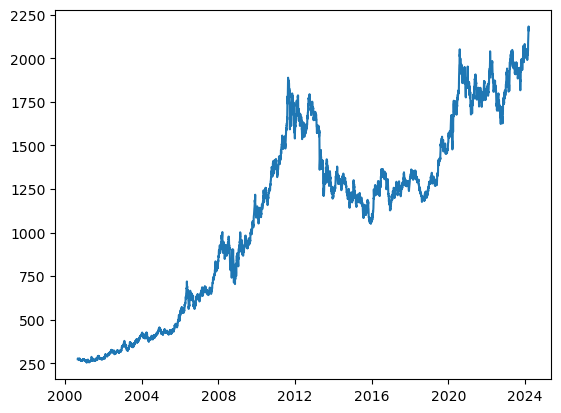

In [3]:
#simple transformations
data.loc[:, 'Date'] = pd.to_datetime(data['Date'])

plt.plot(data['Date'], data['Close'])

In [4]:
device = 'cuda:0' if torch.cuda.is_available() else 'cpu'
device

'cpu'

In [5]:
#takes df from above and creates a lookback window of a week (lookback =7) 
from copy import deepcopy as dc

def prepare_dataframe_for_lstm(df, n_steps):
    df = dc(df)
    
    df.set_index('Date', inplace=True)
    
    #shifts dataframe for each lookback window
    for i in range(1, n_steps+1):
        df[f'Close(t-{i})'] = df['Close'].shift(i)
        
    df.dropna(inplace=True)
    
    return df

lookback = 7
shifted_df = prepare_dataframe_for_lstm(data, lookback)
shifted_df

,Close,Close(t-1),Close(t-2),Close(t-3),Close(t-4),Close(t-5),Close(t-6),Close(t-7)
Date,,,,,,,,
2000-09-11,273.100006,273.299988,274.000000,274.200012,275.799988,277.000000,278.299988,273.899994
2000-09-12,272.899994,273.100006,273.299988,274.000000,274.200012,275.799988,277.000000,278.299988
2000-09-13,272.799988,272.899994,273.100006,273.299988,274.000000,274.200012,275.799988,277.000000
2000-09-14,272.399994,272.799988,272.899994,273.100006,273.299988,274.000000,274.200012,275.799988
2000-09-15,272.299988,272.399994,272.799988,272.899994,273.100006,273.299988,274.000000,274.200012
...,...,...,...,...,...,...,...,...
2024-03-06,2150.300049,2133.500000,2117.699951,2086.899902,2045.699951,2033.000000,2034.000000,2028.500000
2024-03-07,2158.000000,2150.300049,2133.500000,2117.699951,2086.899902,2045.699951,2033.000000,2034.000000
2024-03-08,2178.600098,2158.000000,2150.300049,2133.500000,2117.699951,2086.899902,2045.699951,2033.000000


In [6]:
shifted_df_as_np = shifted_df.to_numpy()

shifted_df_as_np

array([[ 273.1000061 ,  273.29998779,  274.        , ...,  277.        ,
         278.29998779,  273.8999939 ],
       [ 272.8999939 ,  273.1000061 ,  273.29998779, ...,  275.79998779,
         277.        ,  278.29998779],
       [ 272.79998779,  272.8999939 ,  273.1000061 , ...,  274.20001221,
         275.79998779,  277.        ],
       ...,
       [2178.60009766, 2158.        , 2150.30004883, ..., 2086.89990234,
        2045.69995117, 2033.        ],
       [2182.5       , 2178.60009766, 2158.        , ..., 2117.69995117,
        2086.89990234, 2045.69995117],
       [2160.60009766, 2182.5       , 2178.60009766, ..., 2133.5       ,
        2117.69995117, 2086.89990234]])

In [7]:
shifted_df_as_np.shape

(5898, 8)

In [8]:
#runs scaler on data
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler(feature_range=(-1, 1))
shifted_df_as_np = scaler.fit_transform(shifted_df_as_np)

shifted_df_as_np

array([[-0.98132199, -0.98111447, -0.98034833, ..., -0.97668229,
        -0.9750886 , -0.97947375],
       [-0.98152953, -0.98132199, -0.98107618, ..., -0.97795999,
        -0.97648449, -0.97466974],
       [-0.98163331, -0.98152953, -0.98128412, ..., -0.97966354,
        -0.97777302, -0.9760891 ],
       ...,
       [ 0.9959532 ,  0.97457715,  0.97057442, ...,  0.9503832 ,
         0.92268871,  0.94115088],
       [ 1.        ,  0.9959532 ,  0.97858061, ...,  0.98317712,
         0.9669279 ,  0.95501697],
       [ 0.97727519,  1.        ,  1.        , ...,  1.        ,
         1.        ,  1.        ]])

In [9]:
#changes df into x and y
X = shifted_df_as_np[:, 1:]
y = shifted_df_as_np[:, 0]

X.shape, y.shape

((5898, 7), (5898,))

In [10]:
X = dc(np.flip(X, axis=1))
X

array([[-0.97947375, -0.9750886 , -0.97668229, ..., -0.97992537,
        -0.98034833, -0.98111447],
       [-0.97466974, -0.97648449, -0.97795999, ..., -0.98013559,
        -0.98107618, -0.98132199],
       [-0.9760891 , -0.97777302, -0.97966354, ..., -0.98087132,
        -0.98128412, -0.98152953],
       ...,
       [ 0.94115088,  0.92268871,  0.9503832 , ...,  0.97424983,
         0.97057442,  0.97457715],
       [ 0.95501697,  0.9669279 ,  0.98317712, ...,  0.99190714,
         0.97858061,  0.9959532 ],
       [ 1.        ,  1.        ,  1.        , ...,  1.        ,
         1.        ,  1.        ]])

In [11]:
#use first 95% as train and last 5% as test
split_index = int(len(X) * 0.95)

split_index

5603

In [12]:
# splitting into train and test
X_train = X[:split_index]
X_test = X[split_index:]

y_train = y[:split_index]
y_test = y[split_index:]

X_train.shape, X_test.shape, y_train.shape, y_test.shape

((5603, 7), (295, 7), (5603,), (295,))

In [13]:
#PyTorch requires an extra dimension at end
X_train = X_train.reshape((-1, lookback, 1))
X_test = X_test.reshape((-1, lookback, 1))

y_train = y_train.reshape((-1, 1))
y_test = y_test.reshape((-1, 1))

X_train.shape, X_test.shape, y_train.shape, y_test.shape

((5603, 7, 1), (295, 7, 1), (5603, 1), (295, 1))

In [14]:
#wrapping in tensors for PyTorch
X_train = torch.tensor(X_train).float()
y_train = torch.tensor(y_train).float()
X_test = torch.tensor(X_test).float()
y_test = torch.tensor(y_test).float()

X_train.shape, X_test.shape, y_train.shape, y_test.shape

(torch.Size([5603, 7, 1]),
 torch.Size([295, 7, 1]),
 torch.Size([5603, 1]),
 torch.Size([295, 1]))

In [15]:
#need datasets object for PyTorch
#needs to be custom class
from torch.utils.data import Dataset

class TimeSeriesDataset(Dataset):
    def __init__(self, X, y):
        self.X = X
        self.y = y

    def __len__(self):
        return len(self.X)

    def __getitem__(self, i):
        return self.X[i], self.y[i]
    
train_dataset = TimeSeriesDataset(X_train, y_train)
test_dataset = TimeSeriesDataset(X_test, y_test)

In [16]:
train_dataset

In [17]:
# wrap datasets in dataloaders to get batches
# used for iteration
from torch.utils.data import DataLoader

batch_size = 16

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

In [18]:
#gives predicted outputs of arrays
for _, batch in enumerate(train_loader):
    x_batch, y_batch = batch[0].to(device), batch[1].to(device)
    print(x_batch.shape, y_batch.shape)
    break

torch.Size([16, 7, 1]) torch.Size([16, 1])


In [19]:
#takes in number of features, dimensions and number of stacked layers (more layers = more complexity in model)
class LSTM(nn.Module):
    def __init__(self, input_size, hidden_size, num_stacked_layers):
        super().__init__()
        self.hidden_size = hidden_size
        self.num_stacked_layers = num_stacked_layers
        
        #initally use 1 layer to prevent overfitting in training data
        self.lstm = nn.LSTM(input_size, hidden_size, num_stacked_layers, 
                            batch_first=True)
        
        #maps hidden layer to 1. Needed to predict final closing value
        self.fc = nn.Linear(hidden_size, 1)

    def forward(self, x):
        batch_size = x.size(0)
        #initialise LSTM with default h0 and c0
        h0 = torch.zeros(self.num_stacked_layers, batch_size, self.hidden_size).to(device)
        c0 = torch.zeros(self.num_stacked_layers, batch_size, self.hidden_size).to(device)
        
        out, _ = self.lstm(x, (h0, c0))
        #output is gotten from passing varibles in fully connected layer
        out = self.fc(out[:, -1, :])
        return out

#initial model has 1 input size, 4 hidden sizes and 1 stacked layer
#model = LSTM(1, 4, 1)
#Attempt 2:  Increase to 8 hidden units and 2 stacked layers
#model = LSTM(1, 8, 2)  
#Attempt 3:  Increase to 16 hidden units and 4 stacked layers
#model = LSTM(1, 16, 4)
#Attempt 4: Inrcease to 32 hidden unit and 8 stacked layers <----overfitted
#model = LSTM(1, 32, 8)
#Attempt 5:  Increase to 24 hidden units and 6 stacked layers
#model = LSTM(1, 24, 6)
#Attempt 6: 16 hidden units and 1 stacked layer
#model = LSTM(1, 16, 1)
#Attempt 7: 12 hidden units and 1 stacked layer
model = LSTM(1,12,1)
model.to(device)
model

LSTM(
  (lstm): LSTM(1, 12, batch_first=True)
  (fc): Linear(in_features=12, out_features=1, bias=True)
)

In [20]:
#sets model to training mode
def train_one_epoch():
    model.train(True)
    print(f'Epoch: {epoch + 1}')
    running_loss = 0.0
    
    for batch_index, batch in enumerate(train_loader):
        #puts x and y batch onto device we're using 
        x_batch, y_batch = batch[0].to(device), batch[1].to(device)
        
        output = model(x_batch)
        #comparing model's output to ground truth
        #loss is a tensor with a single value
        loss = loss_function(output, y_batch)
        running_loss += loss.item()
        
        #zero out gradients 
        optimizer.zero_grad()
        #backwards pass 
        loss.backward()
        optimizer.step()

        #every 100 batches get avg loss across batches and print
        if batch_index % 100 == 99:  # print every 100 batches
            avg_loss_across_batches = running_loss / 100
            print('Batch {0}, Loss: {1:.3f}'.format(batch_index+1,
                                                    avg_loss_across_batches))
            running_loss = 0.0
    print()

In [21]:
#sets model to validate mode
def validate_one_epoch():
    model.train(False)
    running_loss = 0.0
    
    for batch_index, batch in enumerate(test_loader):
        x_batch, y_batch = batch[0].to(device), batch[1].to(device)
        
        #don't need to calcualte gradient as there's no model updates
        with torch.no_grad():
            output = model(x_batch)
            #compare output to ground truth
            loss = loss_function(output, y_batch)
            running_loss += loss.item()
    #average loss value across all batches
    avg_loss_across_batches = running_loss / len(test_loader)
    
    print('Val Loss: {0:.3f}'.format(avg_loss_across_batches))
    print('***************************************************')
    print()

In [22]:
learning_rate = 0.001
#10 epochs is all that is necessary as any more will cause overfitting
num_epochs = 10
#trying to minimise mean squared error
loss_function = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

for epoch in range(num_epochs):
    train_one_epoch()
    validate_one_epoch()

Epoch: 1
Batch 100, Loss: 0.193
Batch 200, Loss: 0.006
Batch 300, Loss: 0.003

Val Loss: 0.016
***************************************************

Epoch: 2
Batch 100, Loss: 0.002
Batch 200, Loss: 0.002
Batch 300, Loss: 0.001

Val Loss: 0.009
***************************************************

Epoch: 3
Batch 100, Loss: 0.001
Batch 200, Loss: 0.001
Batch 300, Loss: 0.001

Val Loss: 0.004
***************************************************

Epoch: 4
Batch 100, Loss: 0.001
Batch 200, Loss: 0.000
Batch 300, Loss: 0.000

Val Loss: 0.001
***************************************************

Epoch: 5
Batch 100, Loss: 0.000
Batch 200, Loss: 0.000
Batch 300, Loss: 0.000

Val Loss: 0.002
***************************************************

Epoch: 6
Batch 100, Loss: 0.000
Batch 200, Loss: 0.000
Batch 300, Loss: 0.000

Val Loss: 0.001
***************************************************

Epoch: 7
Batch 100, Loss: 0.000
Batch 200, Loss: 0.000
Batch 300, Loss: 0.000

Val Loss: 0.002
*****************

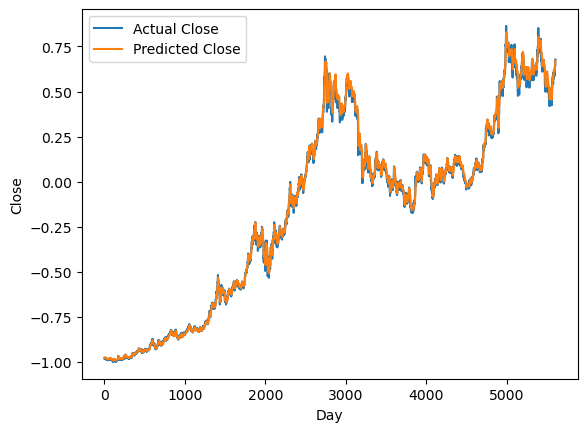

In [23]:
#no gradients for predictions
with torch.no_grad():
    #makes sure it on the device and is put to the CPU (numpy doesn't use GPU)
    predicted = model(X_train.to(device)).to('cpu').numpy()

plt.plot(y_train, label='Actual Close')
plt.plot(predicted, label='Predicted Close')
plt.xlabel('Day')
plt.ylabel('Close')
plt.legend()
plt.show()

In [24]:
#above data still includes scalar begins at -1
#do opposite of earlier transform
train_predictions = predicted.flatten()

#lookback+1 is the length of the whole dataset
dummies = np.zeros((X_train.shape[0], lookback+1))
dummies[:, 0] = train_predictions
dummies = scaler.inverse_transform(dummies)

#return in right scale
train_predictions = dc(dummies[:, 0])
train_predictions

array([ 278.00684345,  277.66317397,  277.05619497, ..., 1848.69388675,
       1857.04241854, 1866.1580174 ])

In [25]:
#first column is no y_train.flatter()
dummies = np.zeros((X_train.shape[0], lookback+1))
dummies[:, 0] = y_train.flatten()
dummies = scaler.inverse_transform(dummies)

new_y_train = dc(dummies[:, 0])
new_y_train

array([ 273.10000381,  272.89999426,  272.79998949, ..., 1864.19996873,
       1872.69997244, 1871.59997736])

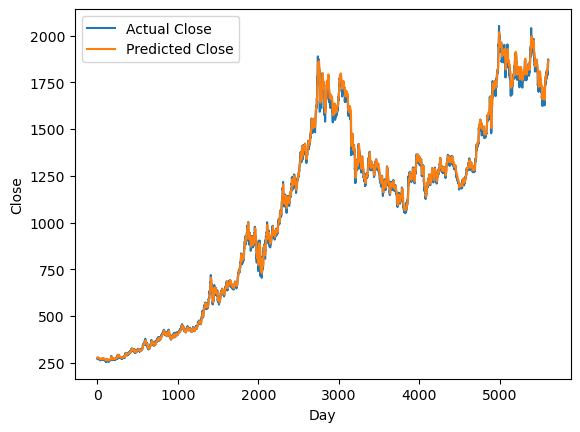

In [26]:
#same graph as earlier with different y_train and predictions
plt.plot(new_y_train, label='Actual Close')
plt.plot(train_predictions, label='Predicted Close')
plt.xlabel('Day')
plt.ylabel('Close')
plt.legend()
plt.show()


In [27]:
#convert to vector of predictions 
test_predictions = model(X_test.to(device)).detach().cpu().numpy().flatten()

dummies = np.zeros((X_test.shape[0], lookback+1))
dummies[:, 0] = test_predictions
dummies = scaler.inverse_transform(dummies)

test_predictions = dc(dummies[:, 0])
test_predictions

array([1873.08884798, 1878.95587131, 1887.31198532, 1898.93143719,
       1906.86599173, 1911.39303151, 1918.00948751, 1924.29485362,
       1929.19617892, 1933.72316126, 1938.40081132, 1940.10703867,
       1940.82453415, 1939.38609673, 1939.1362284 , 1938.61707667,
       1935.67058334, 1921.70748139, 1909.73689271, 1900.85456174,
       1895.41007437, 1889.27721411, 1884.20230212, 1878.63523567,
       1875.80155646, 1869.01823436, 1864.57218639, 1860.81215623,
       1856.79237789, 1853.49727515, 1848.18760181, 1841.58510397,
       1838.25387084, 1838.27633027, 1841.0333832 , 1843.25611998,
       1848.37371064, 1853.2969784 , 1849.91232515, 1845.25437735,
       1844.15788618, 1850.59891738, 1867.88423421, 1882.4512708 ,
       1899.04735312, 1911.83739505, 1931.46544291, 1948.93118191,
       1953.48619546, 1955.96942715, 1966.86770732, 1973.64023051,
       1972.89820773, 1973.92111698, 1973.67521208, 1977.04717087,
       1977.25125873, 1979.08690063, 1989.05877242, 1998.71770

In [28]:
#make ground truth proper scale
dummies = np.zeros((X_test.shape[0], lookback+1))
dummies[:, 0] = y_test.flatten()
dummies = scaler.inverse_transform(dummies)

new_y_test = dc(dummies[:, 0])
new_y_test

array([1874.59994826, 1895.50002697, 1918.40002884, 1907.19995368,
       1904.40004977, 1922.09997572, 1926.40000868, 1927.09998466,
       1933.90002208, 1941.1999685 , 1929.09996525, 1928.59999883,
       1922.90001391, 1929.49998435, 1927.80007552, 1916.30004347,
       1862.90002155, 1866.19994933, 1871.6999247 , 1877.40002449,
       1866.19994933, 1862.80007422, 1851.90001338, 1853.99999875,
       1834.19997255, 1842.00000028, 1840.40003878, 1832.99997271,
       1831.99998241, 1818.00000334, 1808.80002365, 1817.00001304,
       1828.90000673, 1837.69996732, 1833.49999658, 1847.69992775,
       1847.90005218, 1813.90003737, 1812.69992264, 1829.30002583,
       1861.99997859, 1911.69993875, 1906.19996338, 1926.59996079,
       1919.00000005, 1969.80007017, 1979.19994451, 1937.99998805,
       1946.80006352, 1993.80006711, 1982.09996808, 1952.40004366,
       1972.40002197, 1966.09995097, 1980.30005447, 1968.99997453,
       1983.89999657, 2022.19992946, 2020.90003973, 2011.90001

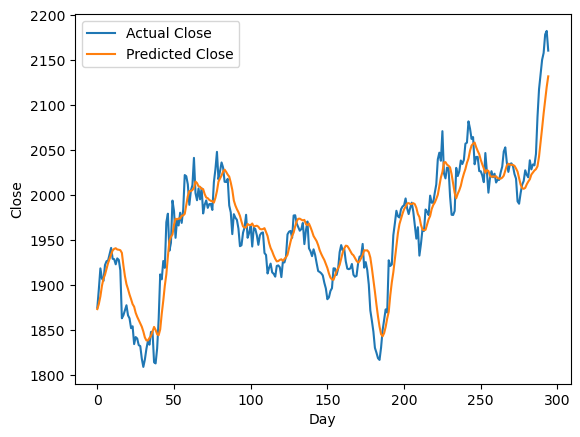

In [29]:
#revised graph with more accurate axises 
plt.plot(new_y_test, label='Actual Close')
plt.plot(test_predictions, label='Predicted Close')
plt.xlabel('Day')
plt.ylabel('Close')
plt.legend()
plt.show()

In [30]:
from math import sqrt
from sklearn.metrics import mean_squared_error, mean_absolute_error
import numpy as np

# For each model, replace `actuals` and `predictions` with the corresponding variables
actuals = new_y_test
predictions = test_predictions

# Calculate the RMSE
rmse = sqrt(mean_squared_error(actuals, predictions))
print("Root Mean Square Error (RMSE):", rmse)

# Calculate Mean Absolute Error (MAE)
mae = mean_absolute_error(actuals, predictions)
print("Mean Absolute Error (MAE):", mae)

# Calculate Mean Absolute Percentage Error (MAPE)
mape = np.mean(np.abs((actuals - predictions) / actuals)) * 100
print("Mean Absolute Percentage Error (MAPE):", mape)


Root Mean Square Error (RMSE): 25.09171933262594
Mean Absolute Error (MAE): 19.22142830382847
Mean Absolute Percentage Error (MAPE): 0.981804083834969


In [31]:
#comparing the RMSE, MAE and MAPE for Training vs Validation data to check for overfitting
from sklearn.metrics import mean_squared_error, mean_absolute_error
import numpy as np
import torch

def evaluate_model(model, data_loader):
    model.eval()  # Set the model to evaluation mode
    predictions, actuals = [], []
    with torch.no_grad():
        for inputs, targets in data_loader:
            inputs, targets = inputs.to(device), targets.to(device)
            outputs = model(inputs)
            predictions.extend(outputs.view(-1).tolist())
            actuals.extend(targets.view(-1).tolist())

    mse = mean_squared_error(actuals, predictions)
    rmse = np.sqrt(mse)
    mae = mean_absolute_error(actuals, predictions)
    mape = np.mean(np.abs((np.array(actuals) - np.array(predictions)) / np.array(actuals))) * 100
    
    return rmse, mae, mape

# Assuming 'train_loader' and 'test_loader' are already defined
# Evaluate the model on training data
train_rmse, train_mae, train_mape = evaluate_model(model, train_loader)
print(f'Training - RMSE: {train_rmse:.3f}, MAE: {train_mae:.3f}, MAPE: {train_mape:.3f}%')

# Evaluate the model on test (validation) data
val_rmse, val_mae, val_mape = evaluate_model(model, test_loader)  # Use test_loader as validation loader
print(f'Validation - RMSE: {val_rmse:.3f}, MAE: {val_mae:.3f}, MAPE: {val_mape:.3f}%')


Training - RMSE: 0.021, MAE: 0.014, MAPE: 29.606%
Validation - RMSE: 0.026, MAE: 0.020, MAPE: 2.623%
